# The logic

Some plates are run mulitple times and many (most?) samples are on multiple plates under different names. Hence, we need to merge all of that to get the full picutre. But we need to check if the merge is supported by the data at hand.

* Check if the mpileups correlate well (I have code from TRD project that can help) -- but what does well mean in that population?
* Merge the files and delete the OG files, BUT
    * Mark run as merged
    * One two-file merge at a time
    * Add each merge event to a growing table with
        * MergeID (counting from 1)
        * Date
        * Filename
        * "Source": Run (folder) / or MergeID


In [1]:
# First of all: Who should be merged?
# For that, we will look at all possible IDs based on the transformed Plate data
# How that file is generated can be seen in Barn_Mice/01_Genotyping/02_Fx/01_ReadstoMpileup/02a_PlateFormatConversion.ipynb

In [2]:
library(tidytable)
source("../../../config.R")
source("../../../extra-R-functions.R")


Attaching package: 'tidytable'


The following objects are masked from 'package:stats':

    dt, filter, lag


The following object is masked from 'package:base':

    %in%


v Reading from Status of mouse sequencing.

v Range ''All founder files''.

v Reading from Status of mouse sequencing.

v Range ''All Fx files''.



In [117]:
merge_history_file<-paste0(folder_for_sequences_fx,"merge_history.tsv")
if(!file.exists(merge_history_file)){
    fwrite(merge_history<-data.table(MergeID=0,Date=NA,Filename=NA,Source=NA),merge_history_file,sep="\t")
}else{
    merge_history<-fread(merge_history_file,sep="\t",header=TRUE)
}
merge_history=filter(merge_history, MergeID>0)
merge_history

MergeID,Date,Filename,Source
<int>,<lgl>,<lgl>,<lgl>


In [3]:
plates=fread("./plates.tsv")

In [4]:
head(plates)

Sample,Pos,Pos2,Plate,Plate2,Plate_final,Final_ID
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
13320,A1,1,NA,m103,m103,m103_01
13321,A2,2,NA,m103,m103,m103_02
13322,A3,3,NA,m103,m103,m103_03
13323,A4,4,NA,m103,m103,m103_04
13324,A5,5,NA,m103,m103,m103_05
13325,A6,6,NA,m103,m103,m103_06


In [5]:
# get the genotype table
GT_df<-readxl::read_xlsx("/moto/home/jr3950/Genotype_Table_20200630.xlsx", col_types = "text")

In [42]:
# get the status file to know which plates are available for merging
# here we also check which plates were sequenced multiple times
status_df=fread(paste0(folder_for_sequences_fx,"status.tsv"))
status_df=filter(status_df, status=="MpileupDone")
head(status_df)
QC_df=fread(paste0(folder_for_sequences_fx,"QC.tsv"), fill=TRUE)
QC_df<-separate(QC_df,Sample,c("run","ignore","sample"),sep="/")%>%select(-ignore)%>%mutate(sample=str_replace(sample,fixed(".bam"),""))%>%select(run,sample)
sequenced_samples<-filter(QC_df,run %in% paste0("run",pull(status_df,runID)))%>%distinct()
head(sequenced_samples)

multiply_sequenced=group_by(sequenced_samples, sample)%>%summarise(n=length(unique(run)))%>%filter(n>1)%>%pull(sample)
multiply_sequenced

runID,status
<int>,<chr>
1,MpileupDone
2,MpileupDone


run,sample
<chr>,<chr>
run1,m078_12
run1,m078_02
run1,m078_04
run1,m078_03
run1,m078_01
run1,m078_06


character(0)

In [60]:
multiply_sampled<-group_by(GT_df, Individual_ID)%>%summarise(n=n())%>%filter(n>1, !(Individual_ID%in%c(NA,"NA","'")))

In [ ]:
get_plate_id=function(lab_id){
    return(plates%>%filter(Sample==lab_id)%>%pull(Final_ID))
}

In [61]:
# first, subset to those samples actually sequenced already for speed

lab_ids=GT_df%>%filter(Individual_ID %in% pull(multiply_sampled, Individual_ID))%>%pull(Lab_ID)
plate_ids=unlist(lapply(lab_ids, get_plate_id))
multiply_sampled<-slice(multiply_sampled, which(plate_ids%in%sequenced_samples$sample))
nrow(multiply_sampled)

[1] 578

In [72]:
get_merge_events=function(x,avail_plate_samples){
    ID=x
    # we use the Individual ID to find plate ids that needs to be merged
    # from the ones that we have sequenced
    lab_ids_to_merge=GT_df%>%filter(Individual_ID == ID)%>%pull(Lab_ID)
    plate_ids_to_merge=unlist(lapply(lab_ids_to_merge, get_plate_id))
    plate_ids_to_merge<-plate_ids_to_merge[plate_ids_to_merge%in%avail_plate_samples$sample]
    if(length(plate_ids_to_merge)<2){
        return(NA)
    }
    plate_ids_to_merge_with_run=data.table(sample=plate_ids_to_merge)%>%left_join(avail_plate_samples)%>%distinct()
    print(paste(paste(plate_ids_to_merge_with_run$run,plate_ids_to_merge_with_run$sample,sep="/"), collapse=" + "))
    return(paste(plate_ids_to_merge_with_run$run,plate_ids_to_merge_with_run$sample,sep="/"))
}

to_merge<-lapply(multiply_sampled$Individual_ID, FUN=get_merge_events, avail_plate_samples=sequenced_samples)



[1] "run2/m025_92 + run2/m038_63"
[1] "run1/m078_16 + run1/m081_18"
[1] "run1/m079_86 + run1/m082_52"
[1] "run1/m079_30 + run1/m083_19 + run1/m083_61"
[1] "run1/m079_68 + run1/m083_27"
[1] "run1/m081_49 + run1/m082_61"
[1] "run1/m079_47 + run1/m082_68"
[1] "run1/m081_03 + run1/m083_64"
[1] "run1/m079_43 + run1/m082_73"
[1] "run1/m080_05 + run1/m082_88"
[1] "run1/m081_50 + run1/m083_21"
[1] "run1/m080_42 + run1/m083_59"
[1] "run1/m078_79 + run1/m081_68 + run1/m082_81"
[1] "run1/m079_89 + run1/m082_60"
[1] "run1/m080_91 + run1/m083_70"
[1] "run1/m079_25 + run1/m083_06"
[1] "run1/m081_87 + run1/m083_22 + run1/m083_60"


In [73]:
names(to_merge)<-multiply_sampled$Individual_ID

In [74]:
head(to_merge)

$`'0006CD44D6`
[1] NA

$`'0006CD44FE`
[1] NA

$`'0006CD4515`
[1] "run2/m025_92" "run2/m038_63"

$`'0006CD4748`
[1] NA

$`'0006CD4767`
[1] NA

$`'0006CD478F`
[1] NA

In [87]:
find_string_in_list <- function(to_merge, target_string) {
  # Loop over the list
  for (name in names(to_merge)) {
      if(is.na(to_merge[[name]][1])){
          next
      }
    # Check if the target string is in the vector
    if (sum(endsWith(to_merge[[name]],target_string))>0) {
      return(name)
    }
  }
  # If the loop completes without finding the string, return NA
  return(NA)
}


In [102]:
# now I need to add those samples in multiply_sequenced, but as Individuals not multiply samples
if(length(multiply_sequenced)>0){
    for(s in multiply_sequenced){
        already_in_list<-find_string_in_list(to_merge,s)
    runs_with_sample<-sequenced_samples%>%filter(sample==s)%>%distinct()%>%pull(run)
    runs_with_sample<-paste0(runs_with_sample,"/",s)
    if(!is.na(already_in_list)){
        # see if all runs are in there
        # otherwise add remaining runs
        to_merge[[already_in_list]]=c(to_merge[[already_in_list]], runs_with_sample)
        to_merge[[already_in_list]]=unique(to_merge[[already_in_list]])
    }else{
        # add new list element with
        # the name of s and all runs of s
        to_merge[[s]]<-runs_with_sample
    }
    }
}

In [105]:
to_merge <- purrr::discard(to_merge, ~all(is.na(.x)))

In [106]:
to_merge

$`'0006CD4515`
[1] "run2/m025_92" "run2/m038_63"

$`'000708C9A8`
[1] "run1/m078_16" "run1/m081_18"

$`'000708CC43`
[1] "run1/m079_86" "run1/m082_52"

$`'000708CC55`
[1] "run1/m079_30" "run1/m083_19" "run1/m083_61"

$`'000708D6D7`
[1] "run1/m079_68" "run1/m083_27"

$`'000708D6E5`
[1] "run1/m081_49" "run1/m082_61"

$`'000708D6E7`
[1] "run1/m079_47" "run1/m082_68"

$`'000708D753`
[1] "run1/m081_03" "run1/m083_64"

$`'000708D8F7`
[1] "run1/m079_43" "run1/m082_73"

$`'000708D981`
[1] "run1/m080_05" "run1/m082_88"

$`'000708DA9A`
[1] "run1/m081_50" "run1/m083_21"

$`'000708DB38`
[1] "run1/m080_42" "run1/m083_59"

$`'000708DBB2`
[1] "run1/m078_79" "run1/m081_68" "run1/m082_81"

$`'000708DCD9`
[1] "run1/m079_89" "run1/m082_60"

$`'000708E125`
[1] "run1/m080_91" "run1/m083_70"

$`'000708E3D9`
[1] "run1/m079_25" "run1/m083_06"

$`'000708E55D`
[1] "run1/m081_87" "run1/m083_22" "run1/m083_60"

In [120]:
# make sure the correlation df is up-to-date
max_cores<-100
for(i in 1:nrow(QC_df)){
    cmd=paste0(Barn_Mice_dir,"01_Genotyping/02_Fx/01_ReadstoMpileup/02a_correlations.R ",folder_for_sequences_fx, " ",
               paste(QC_df$run[i],QC_df$sample[i],sep="/"))
    sbatch_list=execute_complex_sbatch(list_of_cmds = cmd,jobname = jobname<-"mpileup-cors",
                                                   scripts_dir = paste0(bam_dir,"/scripts"), 
                                                   uniqueRunID = str_replace_all(b, fixed("/"), "-"),cores = "1",mem = "4G",time = "short",
                                                   env = env_mapping_etc, initial_timedate = initial_timedate, 
                                                   jobs_simul = max_cores,jobs_total=max_cores,list_of_additional_flags=c(paste0("-A ",slurm_acc)),
                                                  activateEnvScript=paste0(Barn_Mice_dir,"activateEnv.sh"),
                                                  Execute_Sbatches_Env=env_jupyter,username=columbia_username)
    }

    if(exists("sbatch_list") & exists("jobname")){
        if(jobname=="mpileup-cors"){
            start_sbatch_list(sbatch_list, max_cores, jobname, initial_timedate, columbia_username, max_cores)


    }
}
while(slurm_check_jobs_still_running(columbia_username,"mpileup-cors")){
            Sys.sleep(60)
        }

[1] "~/ColumbiaProjects/Barn_Mice/01_Genotyping/02_Fx/01_ReadstoMpileup/02a_correlations.R /moto/ziab/users/jr3950/data/genomes/tmp_Fx/ run1/m078_12"
[1] "~/ColumbiaProjects/Barn_Mice/01_Genotyping/02_Fx/01_ReadstoMpileup/02a_correlations.R /moto/ziab/users/jr3950/data/genomes/tmp_Fx/ run1/m078_02"
[1] "~/ColumbiaProjects/Barn_Mice/01_Genotyping/02_Fx/01_ReadstoMpileup/02a_correlations.R /moto/ziab/users/jr3950/data/genomes/tmp_Fx/ run1/m078_04"
[1] "~/ColumbiaProjects/Barn_Mice/01_Genotyping/02_Fx/01_ReadstoMpileup/02a_correlations.R /moto/ziab/users/jr3950/data/genomes/tmp_Fx/ run1/m078_03"
[1] "~/ColumbiaProjects/Barn_Mice/01_Genotyping/02_Fx/01_ReadstoMpileup/02a_correlations.R /moto/ziab/users/jr3950/data/genomes/tmp_Fx/ run1/m078_01"
[1] "~/ColumbiaProjects/Barn_Mice/01_Genotyping/02_Fx/01_ReadstoMpileup/02a_correlations.R /moto/ziab/users/jr3950/data/genomes/tmp_Fx/ run1/m078_06"
[1] "~/ColumbiaProjects/Barn_Mice/01_Genotyping/02_Fx/01_ReadstoMpileup/02a_correlations.R /moto/zia

In [122]:
# see where the proposed merged fall on the distribution of correlations
cors_filename<-paste0(folder_for_sequences_fx,"cors.txt.gz")
cors_filename_lock<-flock::lock(cors_filename)
cors<-fread(cors_filename, header=TRUE, sep="\t")%>%distinct()
flock::unlock(cors_filename_lock)
head(cors)

sample1,sample2,cor,date
<chr>,<chr>,<dbl>,<dbl>
/moto/ziab/users/jr3950/data/genomes/tmp_Fx/run1/bam/m081_87.bam.mpileup.xz,/moto/ziab/users/jr3950/data/genomes/tmp_Fx/run1/bam/m078_01.bam.mpileup.xz,0.8864230,1684330154
/moto/ziab/users/jr3950/data/genomes/tmp_Fx/run1/bam/m078_01.bam.mpileup.xz,/moto/ziab/users/jr3950/data/genomes/tmp_Fx/run1/bam/m081_87.bam.mpileup.xz,0.8864230,1684330154
/moto/ziab/users/jr3950/data/genomes/tmp_Fx/run1/bam/m081_87.bam.mpileup.xz,/moto/ziab/users/jr3950/data/genomes/tmp_Fx/run1/bam/m078_02.bam.mpileup.xz,0.9029393,1684330160
/moto/ziab/users/jr3950/data/genomes/tmp_Fx/run1/bam/m078_02.bam.mpileup.xz,/moto/ziab/users/jr3950/data/genomes/tmp_Fx/run1/bam/m081_87.bam.mpileup.xz,0.9029393,1684330160
/moto/ziab/users/jr3950/data/genomes/tmp_Fx/run1/bam/m081_87.bam.mpileup.xz,/moto/ziab/users/jr3950/data/genomes/tmp_Fx/run1/bam/m078_03.bam.mpileup.xz,0.8807753,1684330165
/moto/ziab/users/jr3950/data/genomes/tmp_Fx/run1/bam/m078_03.bam.mpileup.xz,/moto/ziab/users/jr3950/data/genomes/tmp_Fx/run1/bam/m081_87.bam.mpileup.xz,0.8807753,1684330165


In [125]:
get_filename=function(focal){
    focal_filename<-strsplit(focal, "/", fixed=TRUE)[[1]]
    focal_filename<-paste0(folder_for_sequences_fx,focal_filename[1],"/bam/",focal_filename[2],".bam.mpileup.xz")
    return(focal_filename)
}

In [132]:
# for each proposed merge, let's get the correlation data
filenames<-unlist(lapply(to_merge[[1]],get_filename))
comparisons<-expand.grid(sample1=filenames,sample2=filenames)%>%filter(sample1!=sample2)
comparisons<-mutate(comparisons,paste=paste(sample1,sample2))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


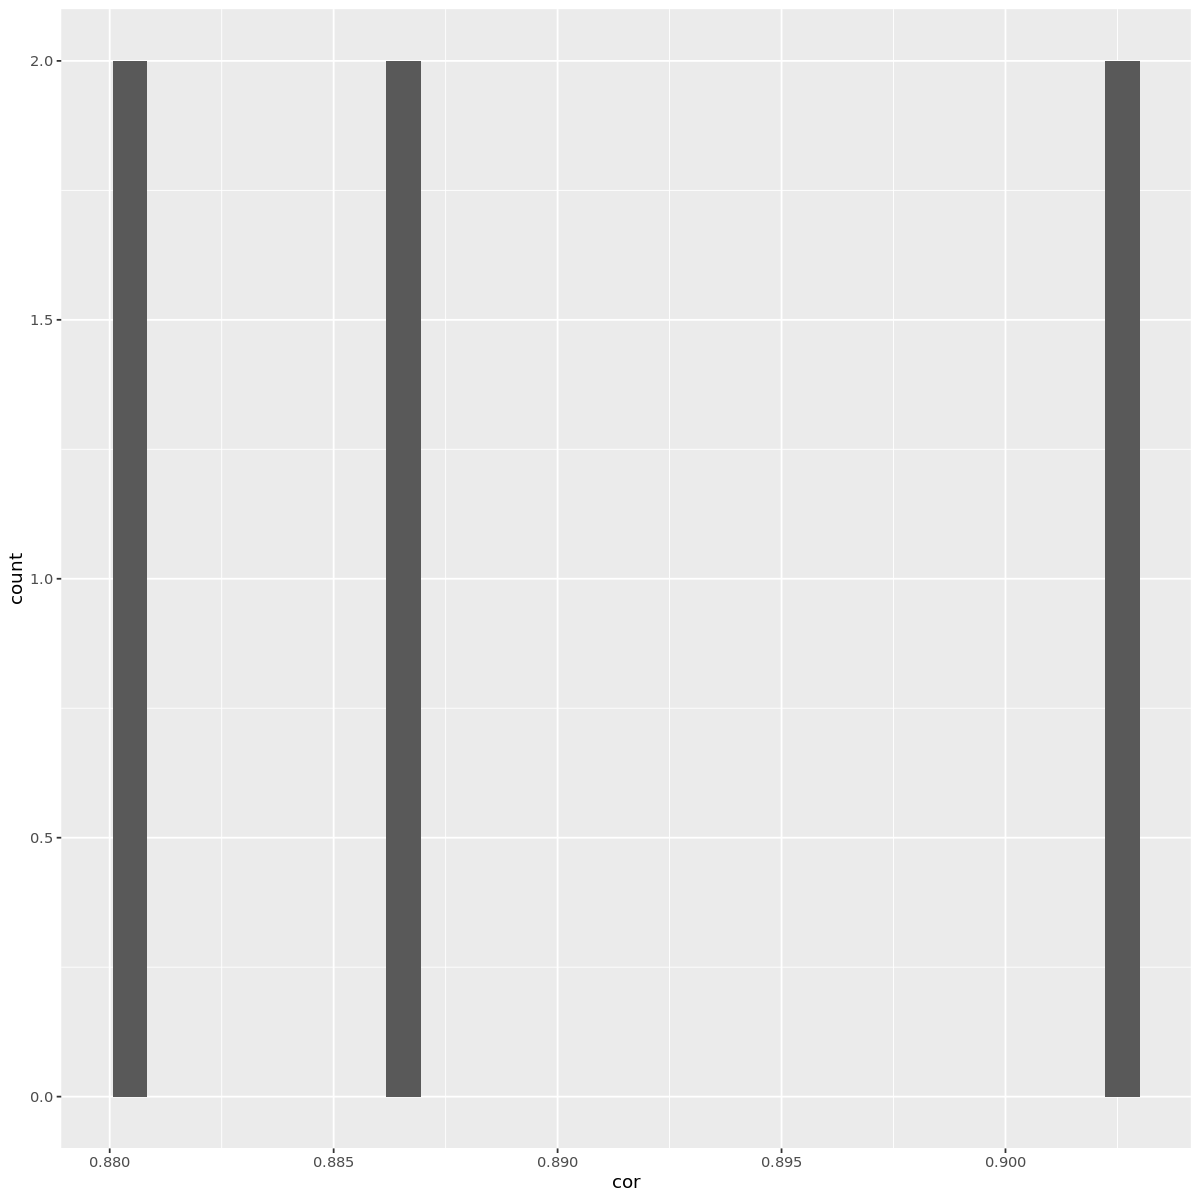

In [134]:
library(ggplot2)
ggplot(cors, aes(cor))+
geom_histogram()+
geom_vline(data=filter(cors,paste(sample1,sample2)%in%pull(comparisons, paste)),mapping=aes(xintercept=cor), color="red")

In [ ]:
# now we can merge
# 02_MergeMpileup.R input1 input2 ouput
# every merge needs to be done, with the output being put in the merged folder (same file name as in the run folders) and the original files being moved
# into a archive subfolder in their respective run/bam folders
# then we need to append a row to the merge history